# ****1.Import Libraries****

In [71]:
import numpy as np 
import pandas as pd 
import warnings
import os
import re
import nltk
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,log_loss,confusion_matrix, f1_score, precision_score, recall_score,auc,roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import scipy
from scipy.sparse import hstack
from gensim.models import Word2Vec
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Input,Dense,Embedding,Conv1D,Conv2D,MaxPooling1D,MaxPool2D
from keras.layers import Reshape,Flatten,Dropout,Concatenate
from keras.layers import SpatialDropout1D,concatenate
from keras.layers import GRU,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D
from keras.callbacks import Callback,LearningRateScheduler,ModelCheckpoint,EarlyStopping
from keras import optimizers
from keras.optimizers import adam_v2
import keras.backend as K
from keras.utils.vis_utils import plot_model
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
#进度条可视化库
import seaborn as sns
from wordcloud import WordCloud
import tensorflow_hub as hub
import tensorflow as tf
from sklearn import metrics
import itertools
#from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
#from keras_bert import AdamWarmup, calc_train_steps

BATCH_SIZE = 64

warnings.filterwarnings("ignore")

local_path = '/kaggle/input/covid19/'
news_path = local_path + 'news.csv'
twitter_path = local_path + 'Twitter.csv'

!pip install tqdm 

In [2]:
#download stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# ****2.Loading Dataset****

In [3]:
#news dataset,twitter dataset
news_data = pd.read_csv(news_path)
twitter_data = pd.read_csv(twitter_path)

In [4]:
news_data.head()

,3,F,"The lie that coronavirus came from a bat or a pangolin is concocted by the Chinese state with the tacit support of the U.S. deep state and its friends in the European Union, Russia and Australia, and spread by the docile media in all of those countries",3.1
0,4,F,The health experts had predicted the virus cou...,3
1,8,F,The Centers for Disease Control and Prevention...,3
2,10,U,Warm weather will kill coronavirus. U.S. Presi...,2
3,15,F,Using a hair dryer to breathe in hot air can c...,2
4,21,T,Washing your hands decreases the number of mic...,2


In [5]:
twitter_data.head()

,No.,label,content,source,sentiment,reply numbers,retweet numbers,likes numbers
0,1,F,"If you can hold your breath without coughing, ...",850196512341262036,3,2.0,61.0,95.0
1,2,F,A homemade hand sanitizer made with Tito's Vod...,8081445194953918218,3,3.0,41.0,67.0
2,3,F,Gargling with salt water or Vinegar 'eliminate...,1803907737236930232,3,6.0,39.0,73.0
3,4,U,Patients should avoid taking ibuprofen to reli...,1989310298994352163,3,0.0,0.0,0.0
4,5,F,Chinese officials are seeking approval to star...,6967004759672387621,4,0.0,0.0,0.0


This project only focus on veracity status,so drop useless columns and renamed useful columns

In [6]:
#drop useless column
news_data.drop(labels = ['3','3.1'] ,axis=1,inplace = True)

In [7]:
#add column name
news_data.columns=['label','content']

In [8]:
#drop useless columns
twitter_data.drop(labels = ['No.','source','sentiment','reply numbers','retweet numbers','likes numbers'] ,
                  axis=1,inplace = True)

In [9]:
#concat two dataset
total_news = pd.concat([news_data,twitter_data],axis=0)

In [10]:
total_news=total_news.reset_index(drop=True)

In [11]:
total_news.head()

,label,content
0,F,The health experts had predicted the virus cou...
1,F,The Centers for Disease Control and Prevention...
2,U,Warm weather will kill coronavirus. U.S. Presi...
3,F,Using a hair dryer to breathe in hot air can c...
4,T,Washing your hands decreases the number of mic...


In [12]:
total_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6833 entries, 0 to 6832
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    6833 non-null   object
 1   content  6833 non-null   object
dtypes: object(2)
memory usage: 106.9+ KB


# ****3.Exploratory Data Analysis****

**3.1 checking missing values**

In [13]:
def check_nullRate():
    nullrate = pd.DataFrame(
        data=[total_news.isna().sum()/len(total_news)*100],
        index=["null rate"]
    )
    return nullrate

In [14]:
check_nullRate()

,label,content
null rate,0.0,0.0


As we can see there is no null data

**3.2 checking labels**

In [15]:
total_news["label"].value_counts()

F             3580
T             1699
U             1553
U(Twitter)       1
Name: label, dtype: int64

Quick look,we have 4 different kind of labels,only 'F'&'T' are useful,so we will handle this problem later.

**3.3 checking target distribution**

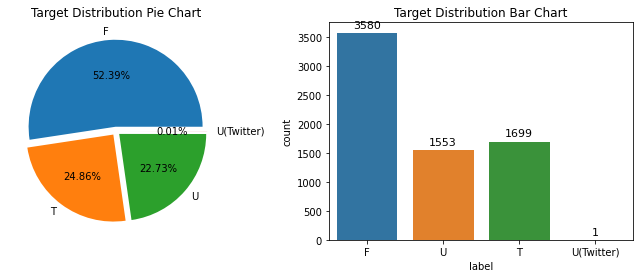

In [16]:
target = total_news['label']
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

target.value_counts().plot(
    kind="pie", 
    explode=[0.05 for x in target.unique()], #饼状图各个模块中间的空隙
    autopct='%.2f%%',#百分比保留位数
    ax=ax[0], #子图位置1
    shadow=False #是否有阴影
)
ax[0].set_title(f"Target Distribution Pie Chart")
ax[0].set_ylabel('')

count = sns.countplot(x="label", data=total_news, ax=ax[1])
for bar in count.patches:
    count.annotate(format(bar.get_height()),#计数
        (bar.get_x() + bar.get_width() / 2,#每个bar的中间位置
         #ha：标注横向位置，va：纵向上位置
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),#标注的字体大小，横纵坐标
        #textcoords横纵坐标的偏移值，offset points：以点为单位
        textcoords='offset points')
ax[1].set_title(f"Target Distribution Bar Chart")
plt.show()

We can see from the figure that the data are imbalanced,fake news are more than twice as much as Real news.We have 3580 (52.39%) fake news and 1699 (24.86%) fake news.

**3.4 checking news length**

In [17]:
total_news['len'] = total_news['content'].apply(len)

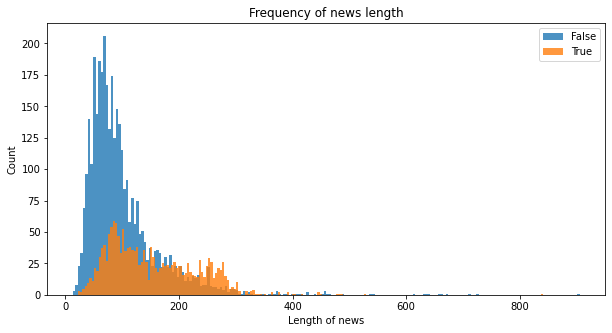

In [18]:
#Plot the frequency of news length
#新闻的长度
bins=200
len_true = total_news[total_news['label']=='T']['content'].apply(len)
len_false = total_news[total_news['label']=='F']['content'].apply(len)
plt.figure(figsize=(10,5))
plt.hist(len_false,label='False',bins=bins,alpha=0.8)
plt.hist(len_true,label='True',bins=bins,alpha=0.8)
plt.xlabel('Length of news')
plt.ylabel('Count')
plt.title('Frequency of news length')
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

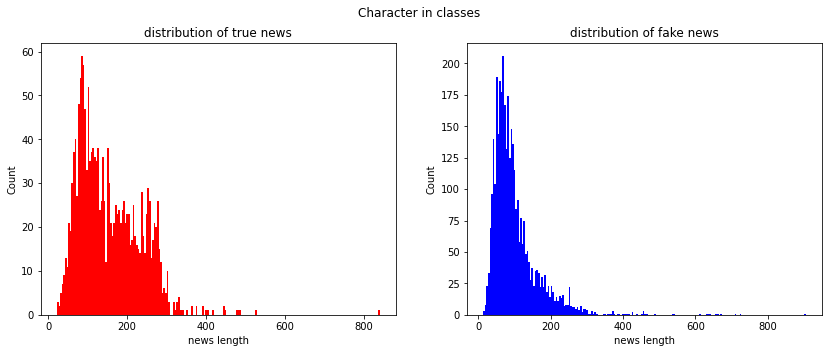

In [19]:
#Frequency of new length in 2 classes
#两种新闻各自的长度
fg = plt.figure()
fg,(ax1,ax2)=plt.subplots(1,2,figsize=(14,5))
ax1.hist(len_true,color='red',bins=200)
ax1.set_title('distribution of true news')
ax1.set_xlabel('news length')
ax1.set_ylabel('Count')
ax2.hist(len_false,color='blue',bins=200)
ax2.set_title('distribution of fake news')
ax2.set_xlabel('news length')
ax2.set_ylabel('Count')
fg.suptitle('Character in classes')
plt.show()

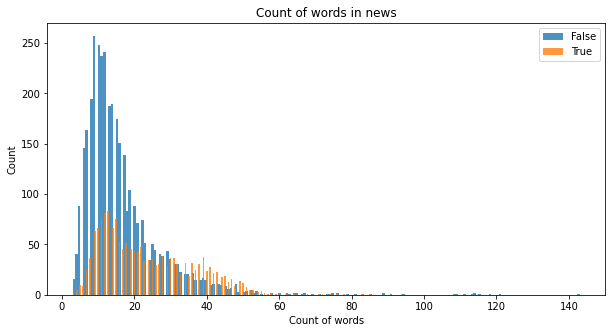

In [20]:
#Plot the frequency of count of words
#新闻中单词的个数
bins=200
words_true = total_news[total_news['label']=='T']['content'].str.split().apply(len)
words_false = total_news[total_news['label']=='F']['content'].str.split().apply(len)
plt.figure(figsize=(10,5))
plt.hist(words_false,label='False',bins=bins,alpha=0.8)
plt.hist(words_true,label='True',bins=bins,alpha=0.8)
plt.xlabel('Count of words')
plt.ylabel('Count')
plt.title('Count of words in news')
plt.legend(loc='best')
plt.show()

It can be seen that almost all the news length are from 0 to 400,and the number of count of words is from 0 to 80,and fake news lenght are over all more than real news.

**3.5 checking top 30 frequent words**

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

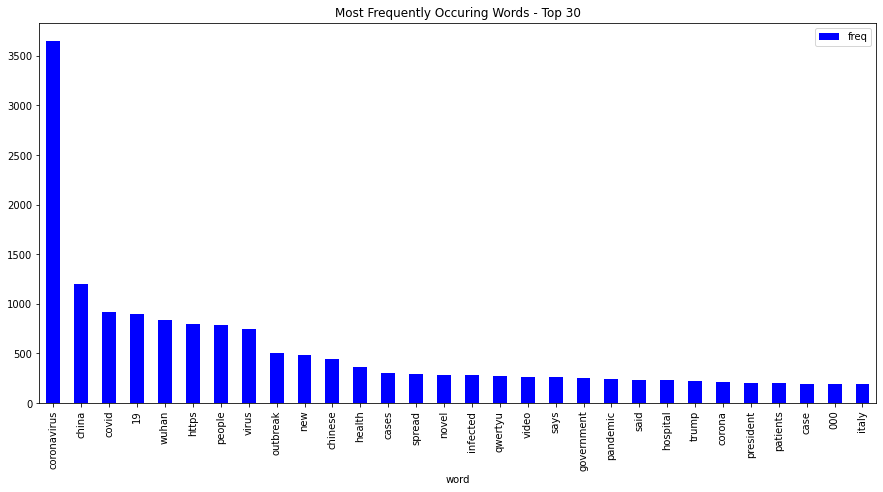

In [21]:
#前30个常见词
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(total_news['content'])

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

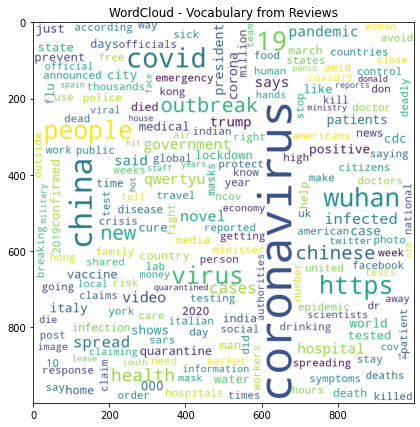

In [22]:
#全部新闻词云
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 12)

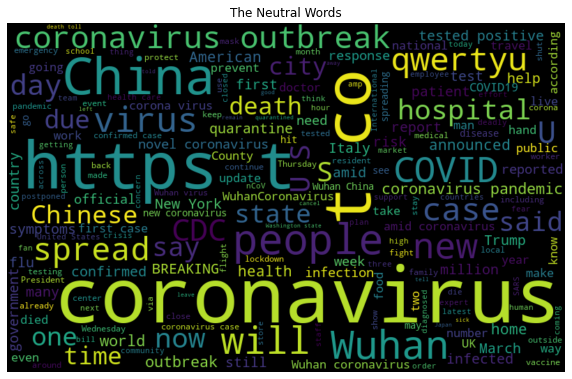

In [23]:
#真新闻词云
normal_words =' '.join([text for text in total_news['content'][total_news['label'] == 'T']])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

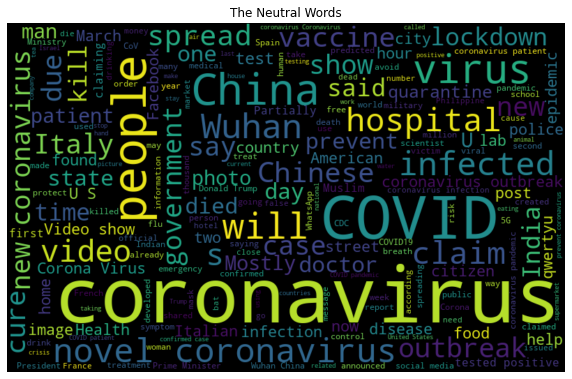

In [24]:
normal_words =' '.join([text for text in total_news['content'][total_news['label'] == 'F']])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

We can see that the top words are the same in both fake and real news,also there are some useless words which cannot be useful features to the model.So we will handle this problem in the next step.After this we focus on the text of news,let's see the top 5 length news.

In [25]:
for news in total_news.sort_values(by="len", ascending=False)["content"][:5]:
    print(f"News: \n{news}\n")

News: 
In case you missed it, yesterday, Federal Agents arrested Dr. Charles Lieber, chair of Harvard University's Department of Chemistry and Chemical Biology, with lying to the Department of Defense about secret monthly payments of $50,000.00 paid by China and receipt of millions more to help set up a chemical/biological   珐esearch ?laboratory in China. Also arrested were two Chinese   藩tudents ?working as research assistants, one of whom was actually a lieutenant in the Chinese Army, the other captured at Logan Airport as he tried to catch a flight to China  ?smuggling 21 vials of   藩ensitive Biological Samples ?according to the FBI. Oh, almost forgot.  The research lab the good professor had helped set up? It's located at the Wuhan University of Technology.  Wuhan China is ground zero to the potentially global pandemic known as the   窅oronavirus  己hich is both spreading rapidly and killing people

News: 
cdnfp  TerryGlavin  rolandparis  nspector4  nytimes  CliveCHamilton  cburton00

**Observations:**
* There are abbrevations in the text
* There are so many symbols/special characters in the text
* Some tweets has mentions & hashtags
* Some tweets also contains HTML character reference

**3.6 checking special characters**

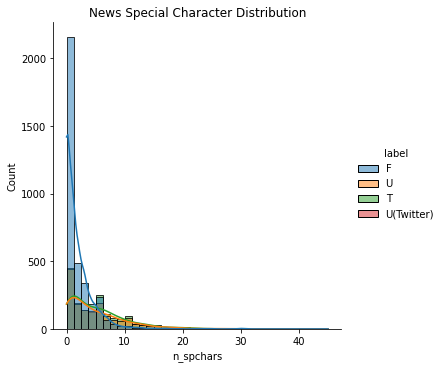


Lowest number of special character in a news: 0
Highest number of special character in a news: 45


In [26]:
total_news["n_spchars"] = total_news["content"].map(lambda x: len(re.findall(r"[\W_]", re.sub(r"\s", "", x))))
#\w是数字字母下划线，\W是非\w，\s是空格制表符换页符
sns.displot(data=total_news, x="n_spchars", kde=True, hue="label", bins=total_news["n_spchars"].nunique())
plt.title("News Special Character Distribution")
plt.show()

print(f"\nLowest number of special character in a news: {total_news['n_spchars'].min()}")
print(f"Highest number of special character in a news: {total_news['n_spchars'].max()}")

Now we see news which contain top 5 number of special characters.

In [27]:
for news in total_news.sort_values(by="n_spchars", ascending=False)["content"][:5]:
    print(f"News: \n{news}\n")

News: 
Michelle: you can’t buy boba bc you’re gonna get the coronavirus bc it’s from Chinese people   🤦🏻‍♂️🤦🏻‍♂️🤦🏻‍♂️🤦🏻‍♂️🤦🏻‍♂️🤦🏻‍♂️🤦🏻‍♂️🤦🏻‍♂�?

News: 
Trump hails 'positive impact' of coronavirus: "It's affecting the airline business...people are staying in our country and they're shopping and they're using our hotels...so from qwertyu same point I think...there's a positive impact," he saidhttps://americanindependent.com/donald-trump-coronavirus-positive-impact-white-house-covid-19/  ?,,EssenViews - Silence Kills Democracy,6:35 AM  ?Mar 5

News: 
There is fear, uncertainty and resignation in #Wuhan as Americans await a government evacuation flight out tonight. Many are forced to ask the tough question: do we go or stay with our Chinese families? Our dispatch:  jamestareddy and  Liz_in_Shanghaihttps://www.wsj.com/articles/americans-in-wuhan-prepare-to-flee-coronavirusor-weather-outbreak-in-isolated-city-11580149927?mod=hp_lead_pos3&mod=article_inline  ?,,Liza Lin,9:58 AM  ?Jan 28

New

# **4.Data Clean**

**Based on the above analysis, we have some findings:**

* There are some useless labels
* Some news' length are too large,which we assigned it as outliers
* There are so many symbols/special characters in the news
* Some news has mentions
* There are some abbreviation
* Some news also contains HTML character reference
* Some news have hashtags
* There is a url in the news
* Now let's clean our data to make it ready to fit to the classification model

**4.1 drop labels except 'F'&'T'**

In [28]:
#delete rows where label not equal to 'F' or 'T'
total_news = total_news[(total_news.label!='U')&(total_news.label!='U(Twitter)')]

In [29]:
total_news.label.value_counts()

F    3580
T    1699
Name: label, dtype: int64

**4.2 drop news which length over 400**

In [30]:
#delete news which length more than 400
total_news.drop(total_news[total_news.content.apply(len)>400].index,inplace=True)

**4.3 preprocess content,remove url,html,emoji,punctuation and transfer abbrevations**

In [31]:
#Pre-process dataset:
def remove_url(text):
    #tweet2 = re.sub(r"https?://\S+|www\.\S+", " ", tweet2)
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
def remove_html(text):
    html=re.compile(r'<,*?>')
    return html.sub(r'',text)
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def remove_stopwords(text):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)


In [32]:
#create a new column store cleaned content
total_news['cleaned_content']  = total_news['content'].apply(lambda x: remove_url(x))
total_news['cleaned_content']  = total_news['cleaned_content'].apply(lambda x: remove_html(x))
total_news['cleaned_content']  = total_news['cleaned_content'].apply(lambda x: remove_emoji(x))
total_news['cleaned_content']  = total_news['cleaned_content'].apply(lambda x: convert_abbrev(x))
total_news['cleaned_content']  = total_news['cleaned_content'].apply(lambda x: convert_abbrev_in_text(x))
total_news['cleaned_content']  = total_news['cleaned_content'].apply(lambda x: remove_punct(x))
#total_news['cleaned_content']  = total_news['cleaned_content'].apply(lambda x: remove_stopwords(x))

In [33]:
#create a new column store cleaned content length,use for padding
total_news['cleaned_len'] = total_news['cleaned_content'].map(len)
total_news['cleaned_len'].describe()

count    5243.000000
mean      113.242800
std        66.450344
min         8.000000
25%        65.000000
50%        92.000000
75%       147.000000
max       404.000000
Name: cleaned_len, dtype: float64

**4.4 Onehot for labels**

In [34]:
#one_hot for labels
#label_one_hot = pd.get_dummies(total_news[['label']])
total_news['label'] = total_news['label'].apply(lambda x: 1 if x =='T' else 0)

Let's check the news which have the most special characters again.

In [35]:
for news in total_news.sort_values(by="n_spchars", ascending=False)["cleaned_content"][:1]:
    print(f"Cleaned News: \n{news}\n")
for news in total_news.sort_values(by="n_spchars", ascending=False)["content"][:1]:
    print(f"News: \n{news}\n")

Cleaned News: 
Trump hails positive impact  of coronavirus   It s affecting the airline business  people are staying in our country and they re shopping and they re using our hotels  so from qwertyu same point I think  there s a positive impact   he said   EssenViews  Silence Kills Democracy635 AM  Mar 5

News: 
Trump hails 'positive impact' of coronavirus: "It's affecting the airline business...people are staying in our country and they're shopping and they're using our hotels...so from qwertyu same point I think...there's a positive impact," he saidhttps://americanindependent.com/donald-trump-coronavirus-positive-impact-white-house-covid-19/  ?,,EssenViews - Silence Kills Democracy,6:35 AM  ?Mar 5



# **5.Feature Engineering**

**5.1 check number of words after data cleaning**

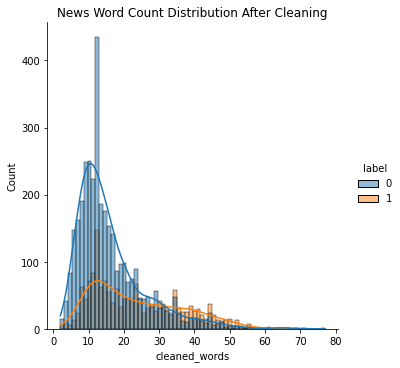


Lowest number of word in a news: 2
Highest number of word in a news: 77


In [36]:
total_news["cleaned_words"] = total_news["cleaned_content"].apply(lambda x: len(re.sub(r"[\W_]", " ", x).split()))

sns.displot(data=total_news, x="cleaned_words", kde=True, hue="label", bins=total_news["cleaned_words"].nunique())
plt.title("News Word Count Distribution After Cleaning")
plt.show()

print(f"\nLowest number of word in a news: {total_news['cleaned_words'].min()}")
print(f"Highest number of word in a news: {total_news['cleaned_words'].max()}")

We can see there is a news only have 2 words after cleaning,let's check it.

In [37]:
display(total_news[total_news.cleaned_words == 2])

print("\nOriginal text:")
for i, text in enumerate(total_news[total_news.cleaned_words == 2]["content"].values):
    print(f"  {i+1}. {text}")

,label,content,len,n_spchars,cleaned_content,cleaned_len,cleaned_words
5671,1,It coming https://t.co/JsGmlmyKwC,33,5,It coming,9,2
5699,1,Sad News https://t.co/r46XrdcmmP,32,5,Sad News,8,2



Original text:
  1. It coming https://t.co/JsGmlmyKwC
  2. Sad News https://t.co/r46XrdcmmP


These two news must be retweets,only several words with url.

**5.2 split dataset**

In [38]:
#train:val:test = 8:1:1
train_set, test_set = train_test_split(total_news, test_size= 0.1, random_state=0)
train_set, val_set = train_test_split(train_set,test_size= 0.1, random_state=1)

check the datasets size

In [39]:
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(4246, 7)
(472, 7)
(525, 7)


**5.3 TF-IDF N-grams**

1.we first use word level n-grams with range(1,2)

In [40]:
vectorizer_word = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='word', 
                             stop_words='english', 
                             ngram_range=(1, 2))

vectorizer_word.fit(train_set['cleaned_content'])

tfidf_matrix_word_train = vectorizer_word.transform(train_set['cleaned_content'])
#tfidf_matrix_word_val = vectorizer_word.transform(val_set['cleaned_content'])
tfidf_matrix_word_test = vectorizer_word.transform(test_set['cleaned_content'])

In [41]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_mean=False)

tfidf_matrix_word_train = sc.fit_transform(tfidf_matrix_word_train)
tfidf_matrix_word_test = sc.fit_transform(tfidf_matrix_word_test)

2.Then use char level 4-grams

In [42]:
vectorizer_char = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='char', 
                             stop_words='english', 
                             ngram_range=(1, 4))

vectorizer_char.fit(train_set['cleaned_content'])

tfidf_matrix_char_train = vectorizer_char.transform(train_set['cleaned_content'])
tfidf_matrix_char_test = vectorizer_char.transform(test_set['cleaned_content'])

3.Fianlly use word+char level n-grams features

In [43]:
tfidf_matrix_word_char_train =  hstack((tfidf_matrix_word_train, tfidf_matrix_char_train))
tfidf_matrix_word_char_test =  hstack((tfidf_matrix_word_test, tfidf_matrix_char_test))

4.After use tf-idf n-grams extract features we use word embedding methods to extract features.

* not pretrained embedding
* pretrained GloVe embedding

In [44]:
MAX_NB_WORDS = 400
tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(train_set['cleaned_content'])
train_sequences = tokenizer.texts_to_sequences(train_set['cleaned_content'])
val_sequences = tokenizer.texts_to_sequences(val_set['cleaned_content'])
test_sequences = tokenizer.texts_to_sequences(test_set['cleaned_content'])
MAX_LENGTH = 80
padded_train_sequences = pad_sequences(train_sequences,maxlen = MAX_LENGTH)
padded_val_sequences = pad_sequences(val_sequences,maxlen = MAX_LENGTH)
padded_test_sequences = pad_sequences(test_sequences,maxlen = MAX_LENGTH)

let's check the shape of matrix and example of features.

In [45]:
print(padded_train_sequences.shape)
print(train_set['cleaned_content'][0])
print(tokenizer.texts_to_sequences([train_set['cleaned_content'][0]]))

(4246, 80)
The health experts had predicted the virus could kill 65 million people in a year
[[1, 41, 117, 289, 1, 22, 195, 153, 135, 19, 5, 6, 185]]


Now we use pre-trained GloVe embedding

In [46]:
def get_coefs(word,*arr):
    try:
        return word,np.asarray(arr,dtype='float32')
    except:
        return None,None
    
embeddings_index = dict(get_coefs(*o.strip().split())
                        for o in tqdm_notebook(open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt')))
embed_size = 300
for k in tqdm_notebook(list(embeddings_index.keys())):
    v= embeddings_index[k]
    try:
        if v.shape != (embed_size,):
            embeddings_index.pop(k)
    except:
        pass
embeddings_index.pop(None)

0it [00:00, ?it/s]

  0%|          | 0/2195886 [00:00<?, ?it/s]

In [47]:
values = list(embeddings_index.values())
all_embs = np.stack(values)
emb_mean,emb_std = all_embs.mean(),all_embs.std()
word_index = tokenizer.word_index
nb_words = MAX_NB_WORDS
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

# **6.Modeling**

This project use logistic regression,RNN,CNN and RNN+CNN as classifier to detect fake news.

**6.1 Machine learning**

We first use logistic regression with tf-idf n-grams to classify news.

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
lr_word = LogisticRegression(solver='sag', verbose=2)
#sag：即随机平均梯度下降，是梯度下降法的变种，和普通梯度下降法的区别是每次迭代仅仅⽤⼀部分的样本来计算梯度，适合于样本数据多的时候。
lr_word.fit(tfidf_matrix_word_train, train_set['label'])

max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(solver='sag', verbose=2)

In [50]:
lr_char = LogisticRegression(solver='sag', verbose=2)
lr_char.fit(tfidf_matrix_char_train, train_set['label'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


LogisticRegression(solver='sag', verbose=2)

In [51]:
lr_word_char = LogisticRegression(solver='sag', verbose=2)
lr_word_char.fit(tfidf_matrix_word_char_train, train_set['label'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.35495429
Epoch 3, change: 0.17880265
Epoch 4, change: 0.10239844
Epoch 5, change: 0.06512070
Epoch 6, change: 0.04741930
Epoch 7, change: 0.03807809
Epoch 8, change: 0.03455138
Epoch 9, change: 0.03088743
Epoch 10, change: 0.02771564
Epoch 11, change: 0.02576981
Epoch 12, change: 0.02378911
Epoch 13, change: 0.02186994
Epoch 14, change: 0.02012593
Epoch 15, change: 0.01855098
Epoch 16, change: 0.01749337
Epoch 17, change: 0.01687210
Epoch 18, change: 0.01619184
Epoch 19, change: 0.01502021
Epoch 20, change: 0.01420403
Epoch 21, change: 0.01367818
Epoch 22, change: 0.01308425
Epoch 23, change: 0.01246327
Epoch 24, change: 0.01196793
Epoch 25, change: 0.01156110
Epoch 26, change: 0.01130366
Epoch 27, change: 0.01093210
Epoch 28, change: 0.01063254
Epoch 29, change: 0.01029795
Epoch 30, change: 0.01002178
Epoch 31, change: 0.00981725
Epoch 32, change: 0.00943631
Epoch 33, change: 0.00922067
Epoch 34, change: 0.00898421
Epoch 35, change: 0.008

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


LogisticRegression(solver='sag', verbose=2)

**6.2 RNN with and without GloVe embeddings**

1.first we need to build a function to record the training process.

In [52]:
#loss curve
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_accuracy = {'batch':[], 'epoch':[]}
        
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_accuracy['batch'].append(logs.get('val_accurcay'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_accuracy['epoch'].append(logs.get('val_accuracy'))
         
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_accuracy[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

2022-09-01 07:05:07.424434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 07:05:07.534701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 07:05:07.535556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 07:05:07.537200: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

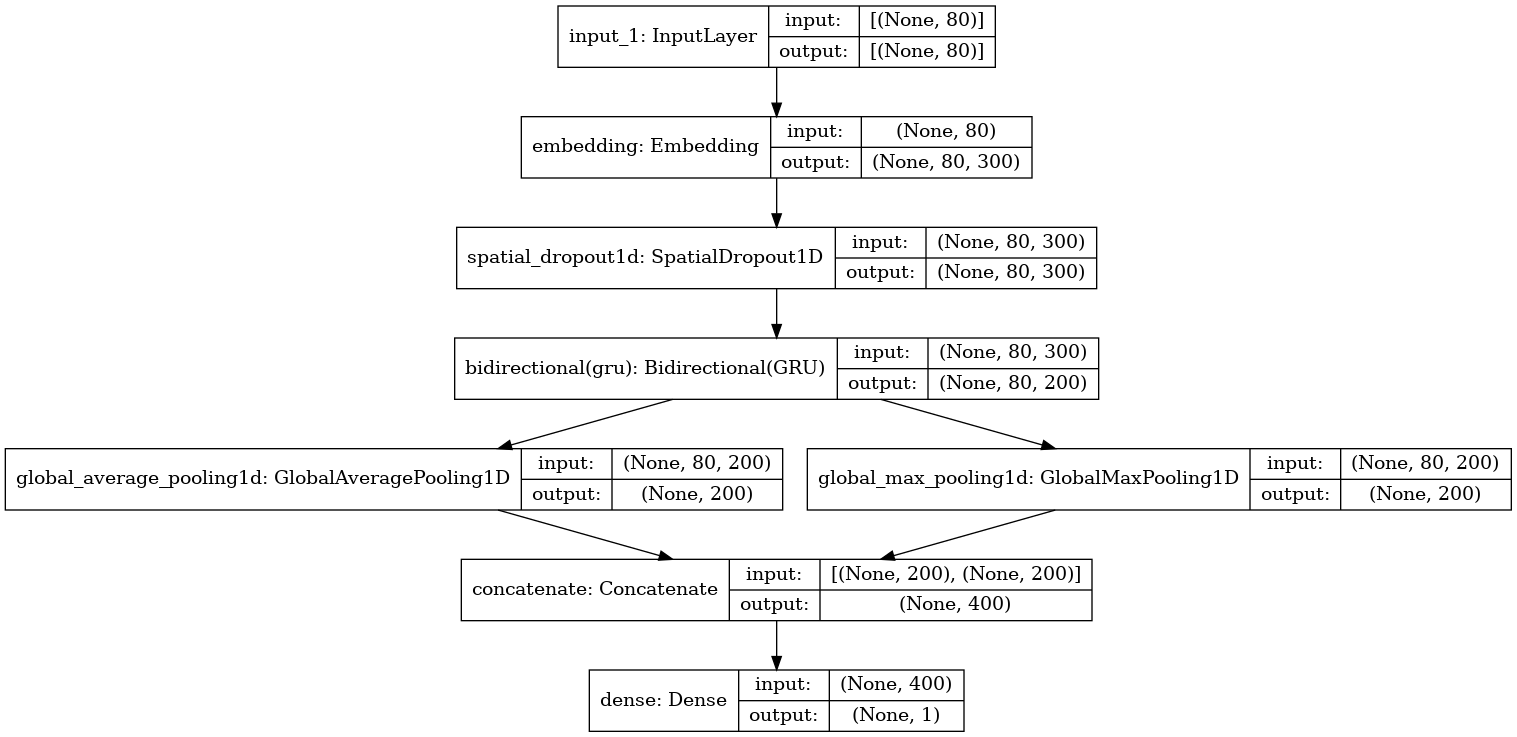

In [53]:
def MyRNN():
    embedding_dim = 300
    embedding_matrix = np.random.random((MAX_NB_WORDS,embedding_dim))
    
    inp = Input(shape = (MAX_LENGTH,))
    x= Embedding(input_dim=MAX_NB_WORDS,output_dim = embedding_dim,input_length = MAX_LENGTH,
                weights = [embedding_matrix],trainable = True)(inp)
    x= SpatialDropout1D(0.5)(x)
    x= Bidirectional(GRU(100,return_sequences = True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool,max_pool])
    outp = Dense(1,activation = 'sigmoid')(conc)
    
    model = Model(inputs= inp,outputs = outp)
    optimizer = optimizers.adam_v2.Adam(lr=5e-4)
    model.compile(loss='binary_crossentropy',
                 optimizer = optimizer,
                 metrics = ['accuracy'])
    return model
myrnn = MyRNN()
plot_model(myrnn,
          show_shapes=True,
          show_layer_names=True)

In [54]:
filepath='./kaggle/working/myrnn/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath,monitor='accuracy',verbose=1,save_best_only=True,mode = 'max')
history_rnn=LossHistory()
batch_size = 128
epochs = 30
history = myrnn.fit(x= padded_train_sequences,
                   y= train_set['label'],
                   validation_data = (padded_val_sequences,val_set['label']),
                   batch_size = batch_size,
                   callbacks = [history_rnn],
                   epochs = epochs,
                   verbose = 1)
#verbose：日志显示,verbose = 0 为不在标准输出流输出日志信息
#verbose = 1 为输出进度条记录,verbose = 2 为每个epoch输出一行记录,注意： 默认为 1

2022-09-01 07:05:12.171724: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-09-01 07:05:16.112798: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


34/34 [==============================] - 7s 40ms/step - loss: 0.6414 - accuracy: 0.6583 - val_loss: 0.6857 - val_accuracy: 0.6610
Epoch 2/30
34/34 [==============================] - 1s 20ms/step - loss: 0.6183 - accuracy: 0.6823 - val_loss: 0.6062 - val_accuracy: 0.6610
Epoch 3/30
34/34 [==============================] - 1s 17ms/step - loss: 0.5982 - accuracy: 0.6844 - val_loss: 0.5751 - val_accuracy: 0.6695
Epoch 4/30
34/34 [==============================] - 1s 16ms/step - loss: 0.5804 - accuracy: 0.7011 - val_loss: 0.5510 - val_accuracy: 0.7097
Epoch 5/30
34/34 [==============================] - 1s 17ms/step - loss: 0.5687 - accuracy: 0.7030 - val_loss: 0.5293 - val_accuracy: 0.7352
Epoch 6/30
34/34 [==============================] - 1s 18ms/step - loss: 0.5541 - accuracy: 0.7138 - val_loss: 0.5261 - val_accuracy: 0.6970
Epoch 7/30
34/34 [==============================] - 1s 17ms/step - loss: 0.5401 - accuracy: 0.7252 - val_loss: 0.5241 - val_accuracy: 0.6949
Epoch 8/30
34/34 [======

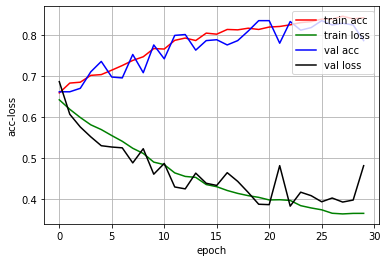

In [55]:
history_rnn.loss_plot('epoch')

  0%|          | 0/9792 [00:00<?, ?it/s]

3


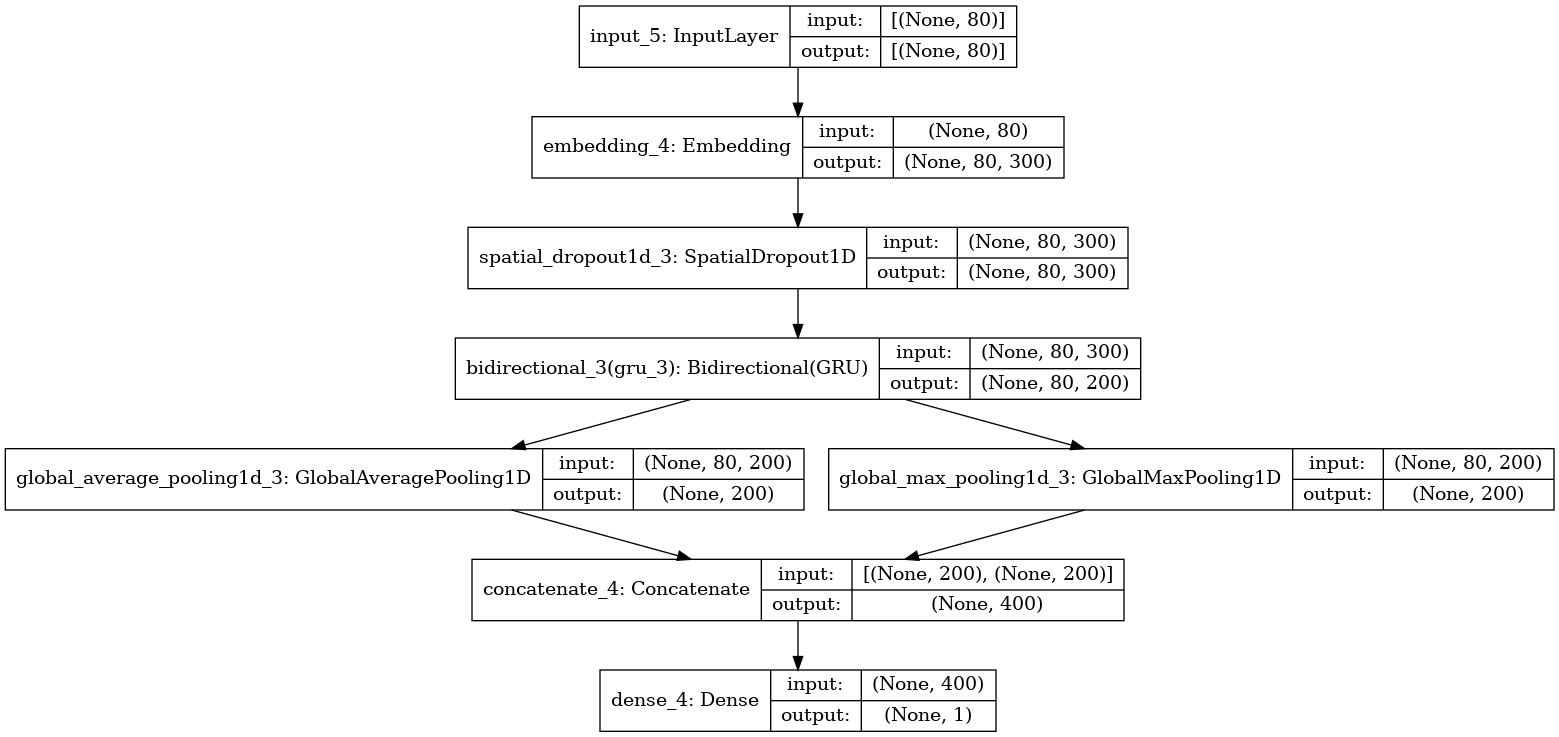

In [100]:
oov = 0
for word, i in tqdm_notebook(word_index.items()):
    if i >= MAX_NB_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        oov += 1

print(oov)

def MyRNN_with_glove_embeddings():
    embedding_dim = 300
    inp = Input(shape=(MAX_LENGTH, ))
    x = Embedding(MAX_NB_WORDS, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)(inp)
    x = SpatialDropout1D(0.5)(x)
    x = Bidirectional(GRU(100, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    optimizer = optimizers.adam_v2.Adam(lr=5e-4)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model
myrnn_with_embeddings = MyRNN_with_glove_embeddings()
plot_model(myrnn_with_embeddings,
          show_shapes=True,
          show_layer_names=True)

In [57]:
filepath="./kaggle/working/models/myrnn_with_embeddings/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
history_rnn_embed=LossHistory()
batch_size = 256
epochs = 20

history = myrnn_with_embeddings.fit(x=padded_train_sequences, 
                    y=train_set['label'], 
                    validation_data=(padded_val_sequences, val_set['label']), 
                    batch_size=batch_size, 
                    callbacks=[history_rnn_embed], 
                    epochs=epochs, 
                    verbose=1)

Epoch 1/20
17/17 [==============================] - 4s 58ms/step - loss: 0.6502 - accuracy: 0.6627 - val_loss: 0.6179 - val_accuracy: 0.6610
Epoch 2/20
17/17 [==============================] - 0s 24ms/step - loss: 0.6040 - accuracy: 0.6861 - val_loss: 0.5796 - val_accuracy: 0.6674
Epoch 3/20
17/17 [==============================] - 0s 24ms/step - loss: 0.5777 - accuracy: 0.6924 - val_loss: 0.5533 - val_accuracy: 0.7161
Epoch 4/20
17/17 [==============================] - 0s 24ms/step - loss: 0.5600 - accuracy: 0.7134 - val_loss: 0.5305 - val_accuracy: 0.7288
Epoch 5/20
17/17 [==============================] - 0s 24ms/step - loss: 0.5395 - accuracy: 0.7289 - val_loss: 0.5081 - val_accuracy: 0.7436
Epoch 6/20
17/17 [==============================] - 0s 24ms/step - loss: 0.5165 - accuracy: 0.7475 - val_loss: 0.4798 - val_accuracy: 0.7839
Epoch 7/20
17/17 [==============================] - 0s 24ms/step - loss: 0.4970 - accuracy: 0.7640 - val_loss: 0.4498 - val_accuracy: 0.8114
Epoch 8/20
17

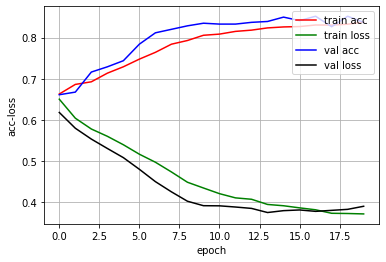

In [58]:
history_rnn_embed.loss_plot('epoch')

**6.3 CNN with GloVe embedding**

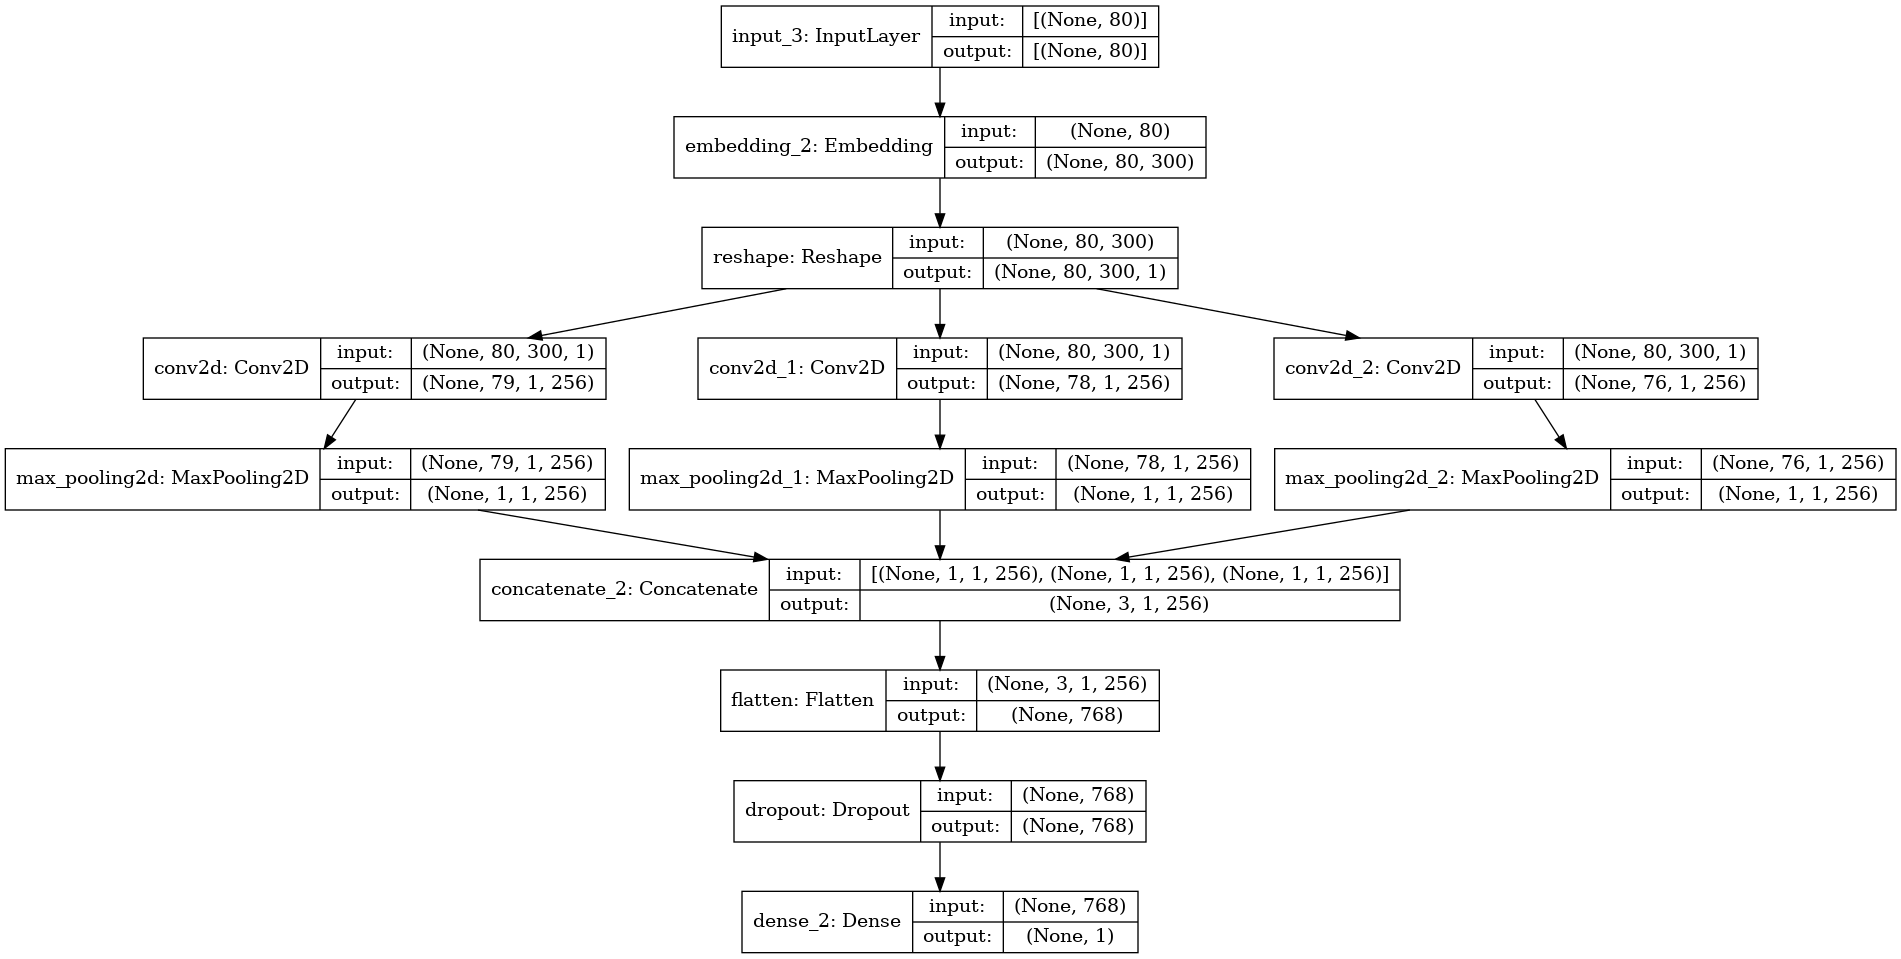

In [59]:
def MyCNN_model():
    embedding_dim = 300
    
    filter_sizes = [2, 3, 5]
    num_filters = 256
    drop = 0.3

    inputs = Input(shape=(MAX_LENGTH,), dtype='int32')
    embedding = Embedding(input_dim=MAX_NB_WORDS,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=MAX_LENGTH,
                                trainable=True)(inputs)

    reshape = Reshape((MAX_LENGTH, embedding_dim, 1))(embedding)
    conv_0 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[0], embedding_dim), 
                    padding='valid', kernel_initializer='normal', 
                    activation='relu')(reshape)

    conv_1 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[1], embedding_dim), 
                    padding='valid', kernel_initializer='normal', 
                    activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[2], embedding_dim), 
                    padding='valid', kernel_initializer='normal', 
                    activation='relu')(reshape)

    maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), 
                          strides=(1,1), padding='valid')(conv_0)

    maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), 
                          strides=(1,1), padding='valid')(conv_1)

    maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), 
                          strides=(1,1), padding='valid')(conv_2)
    concatenated_tensor = Concatenate(axis=1)(
        [maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=1, activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=output)
    adam = adam_v2.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
mycnn = MyCNN_model()
plot_model(mycnn, 
           #to_file='./kaggle/working/images/MyCNN.png', 
           show_shapes=True, 
           show_layer_names=True)

In [60]:
filepath="./kaggle/working/models/mycnn/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
history_cnn = LossHistory()
batch_size = 256
epochs = 40
mycnn.fit(x=padded_train_sequences, 
          y=train_set['label'], 
          validation_data=(padded_val_sequences, val_set['label']), 
          batch_size=batch_size, 
          callbacks=[history_cnn], 
          epochs=epochs, 
          verbose=1)

Epoch 1/40
17/17 [==============================] - 19s 345ms/step - loss: 0.6910 - accuracy: 0.6335 - val_loss: 0.5684 - val_accuracy: 0.6780
Epoch 2/40
17/17 [==============================] - 1s 38ms/step - loss: 0.5967 - accuracy: 0.6919 - val_loss: 0.5174 - val_accuracy: 0.7394
Epoch 3/40
17/17 [==============================] - 1s 38ms/step - loss: 0.5558 - accuracy: 0.7195 - val_loss: 0.4860 - val_accuracy: 0.7585
Epoch 4/40
17/17 [==============================] - 1s 38ms/step - loss: 0.5179 - accuracy: 0.7400 - val_loss: 0.4765 - val_accuracy: 0.7479
Epoch 5/40
17/17 [==============================] - 1s 38ms/step - loss: 0.4932 - accuracy: 0.7560 - val_loss: 0.4750 - val_accuracy: 0.7436
Epoch 6/40
17/17 [==============================] - 1s 39ms/step - loss: 0.4775 - accuracy: 0.7718 - val_loss: 0.4598 - val_accuracy: 0.7669
Epoch 7/40
17/17 [==============================] - 1s 38ms/step - loss: 0.4615 - accuracy: 0.7833 - val_loss: 0.4360 - val_accuracy: 0.7754
Epoch 8/40


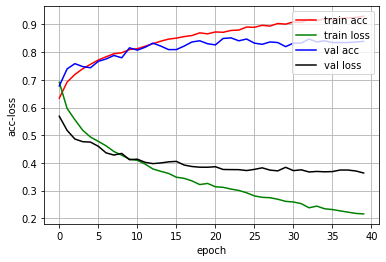

In [61]:
history_cnn.loss_plot('epoch')

**6.4 RNN+CNN with GloVe embedding**

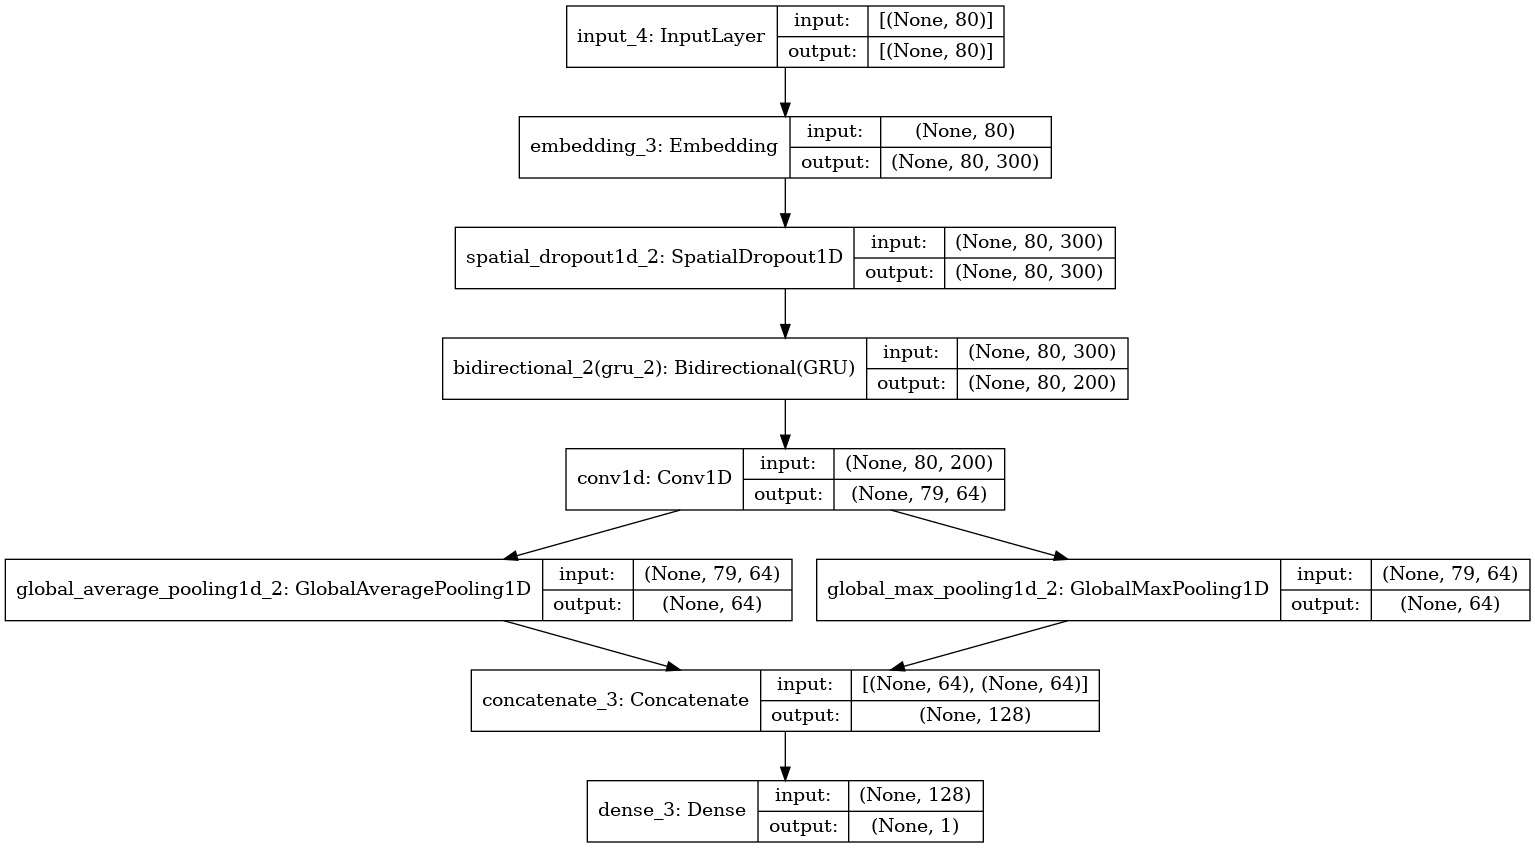

In [62]:
def my_RNN_CNN_model():
    embedding_dim = 300
    inp = Input(shape=(MAX_LENGTH, ))
    x = Embedding(MAX_NB_WORDS, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)(inp)
    x = SpatialDropout1D(0.5)(x)
    x = Bidirectional(GRU(100, return_sequences=True))(x)
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    adam = adam_v2.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    return model
my_rnn_cnn_model = my_RNN_CNN_model()
plot_model(my_rnn_cnn_model, 
           #to_file='./images/article_5/rnn_cnn_model.png', 
           show_shapes=True, show_layer_names=True)

In [63]:
filepath="./kaggle/working/models/my_rnn_cnn/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
history_rnncnn = LossHistory()
batch_size = 128
epochs = 40

history = my_rnn_cnn_model.fit(x=padded_train_sequences, 
                    y=train_set['label'], 
                    validation_data=(padded_val_sequences, val_set['label']), 
                    batch_size=batch_size, 
                    callbacks=[history_rnncnn], 
                    epochs=epochs, 
                    verbose=1)

Epoch 1/40
34/34 [==============================] - 4s 37ms/step - loss: 0.6265 - accuracy: 0.6707 - val_loss: 0.6008 - val_accuracy: 0.6631
Epoch 2/40
34/34 [==============================] - 1s 18ms/step - loss: 0.6049 - accuracy: 0.6868 - val_loss: 0.5789 - val_accuracy: 0.6653
Epoch 3/40
34/34 [==============================] - 1s 17ms/step - loss: 0.5824 - accuracy: 0.6957 - val_loss: 0.5659 - val_accuracy: 0.6716
Epoch 4/40
34/34 [==============================] - 1s 19ms/step - loss: 0.5768 - accuracy: 0.6962 - val_loss: 0.5488 - val_accuracy: 0.6949
Epoch 5/40
34/34 [==============================] - 1s 18ms/step - loss: 0.5681 - accuracy: 0.7115 - val_loss: 0.5372 - val_accuracy: 0.7140
Epoch 6/40
34/34 [==============================] - 1s 17ms/step - loss: 0.5546 - accuracy: 0.7174 - val_loss: 0.5230 - val_accuracy: 0.7458
Epoch 7/40
34/34 [==============================] - 1s 17ms/step - loss: 0.5383 - accuracy: 0.7322 - val_loss: 0.5311 - val_accuracy: 0.6992
Epoch 8/40
34

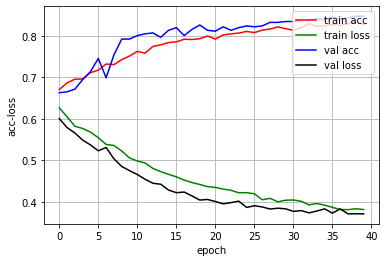

In [64]:
history_rnncnn.loss_plot('epoch')

# **7.Evaluation**

First we build a function to calculate precision,recall and F1score.

In [65]:
def metric_precision(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision=TP/(TP+FP)
    return precision

def metric_recall(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    recall=TP/(TP+FN)
    return recall

def metric_F1score(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    F1score=2*precision*recall/(precision+recall)
    return F1score

**7.1 Logistic regression**

In [66]:
y_pred_word = lr_word.predict(tfidf_matrix_word_test)
print(accuracy_score(test_set['label'],y_pred_word))
print(metric_precision(test_set['label'],y_pred_word))
print(metric_recall(test_set['label'],y_pred_word))
print(metric_F1score(test_set['label'],y_pred_word))

0.7771428571428571
tf.Tensor(0.6480446927374302, shape=(), dtype=float64)
tf.Tensor(0.6823529411764706, shape=(), dtype=float64)
tf.Tensor(0.664756446991404, shape=(), dtype=float64)


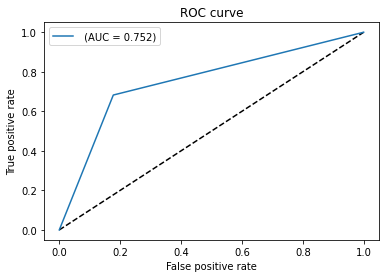

In [67]:
fpr_w, tpr_w, thresholds_w = roc_curve(test_set['label'], y_pred_word)
auc_w = auc(fpr_w, tpr_w)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_w, tpr_w, label=' (AUC = {:.3f})'.format(auc_w))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Confusion matrix, without normalization


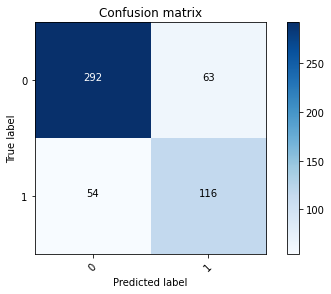

In [72]:
cm = metrics.confusion_matrix(test_set['label'], y_pred_word , labels=[0, 1])
plot_confusion_matrix(cm, classes=[0, 1])

In [73]:
y_pred_char = lr_char.predict(tfidf_matrix_char_test)
print(accuracy_score(test_set['label'],y_pred_char))
print(metric_precision(test_set['label'],y_pred_char))
print(metric_recall(test_set['label'],y_pred_char))
print(metric_F1score(test_set['label'],y_pred_char))

0.8095238095238095
tf.Tensor(0.8181818181818182, shape=(), dtype=float64)
tf.Tensor(0.5294117647058824, shape=(), dtype=float64)
tf.Tensor(0.6428571428571428, shape=(), dtype=float64)


Confusion matrix, without normalization


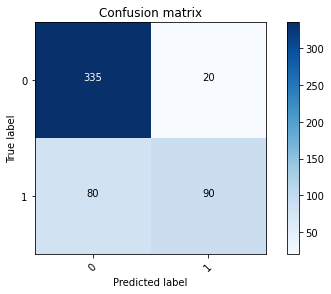

In [74]:
cm = metrics.confusion_matrix(test_set['label'], y_pred_char , labels=[0, 1])
plot_confusion_matrix(cm, classes=[0, 1])

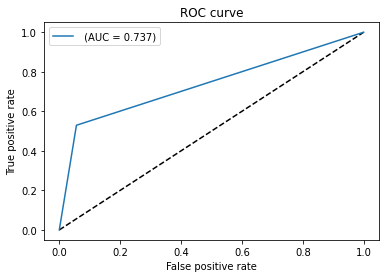

In [75]:
fpr_c, tpr_c, thresholds_c = roc_curve(test_set['label'], y_pred_char)
auc_c = auc(fpr_c, tpr_c)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_c, tpr_c, label=' (AUC = {:.3f})'.format(auc_c))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [76]:
y_pred_word_char = lr_word_char.predict(tfidf_matrix_word_char_test)
print(accuracy_score(test_set['label'],y_pred_word_char))
print(metric_precision(test_set['label'],y_pred_word_char))
print(metric_recall(test_set['label'],y_pred_word_char))
print(metric_F1score(test_set['label'],y_pred_word_char))

0.7790476190476191
tf.Tensor(0.6534090909090909, shape=(), dtype=float64)
tf.Tensor(0.6764705882352942, shape=(), dtype=float64)
tf.Tensor(0.6647398843930635, shape=(), dtype=float64)


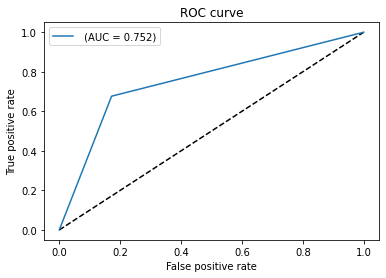

In [77]:
fpr_wc, tpr_wc, thresholds_wc = roc_curve(test_set['label'], y_pred_word_char)
auc_wc = auc(fpr_wc, tpr_wc)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_wc, tpr_wc, label=' (AUC = {:.3f})'.format(auc_wc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Confusion matrix, without normalization


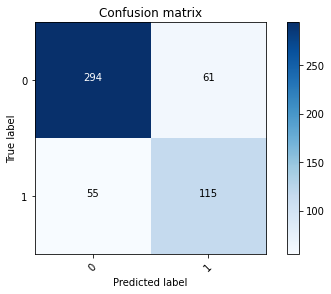

In [78]:
cm = metrics.confusion_matrix(test_set['label'], y_pred_word_char , labels=[0, 1])
plot_confusion_matrix(cm, classes=[0, 1])

**7.2 RNN without pre-trained embedding**

In [79]:
score = myrnn.evaluate(padded_val_sequences, val_set['label'], verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.4805386960506439
Test accuracy: 0.7860169410705566


In [80]:
y_pred_myrnn = myrnn.predict(padded_test_sequences, verbose=1, batch_size=2048).ravel()
y_pred_myrnn = pd.DataFrame(y_pred_myrnn, columns=['prediction'])
y_pred_myrnn['prediction'] = y_pred_myrnn['prediction'].map(lambda p: 1 if p >= 0.5 else 0)
fpr_rnn, tpr_rnn, thresholds_rnn = roc_curve(test_set['label'], y_pred_myrnn)
auc_rnn = auc(fpr_rnn, tpr_rnn)

1/1 [==============================] - 1s 565ms/step


In [81]:
#y_pred_myrnn = pd.read_csv('./kaggle/working/predictions/y_pred_myrnn.csv')
#best_myrnn = load_model('./kaggle/working/myrnn/weights-improvement-16-0.9138.hdf5')
#y_pred_myrnn = best_myrnn.predict(
    #padded_test_sequences, verbose=1, batch_size=2048)
print(accuracy_score(test_set['label'],y_pred_myrnn['prediction']))
print(metric_precision(test_set['label'],y_pred_myrnn['prediction']))
print(metric_recall(test_set['label'],y_pred_myrnn['prediction']))
print(metric_F1score(test_set['label'],y_pred_myrnn['prediction']))

0.7904761904761904
tf.Tensor(0.7830188679245284, shape=(), dtype=float64)
tf.Tensor(0.48823529411764705, shape=(), dtype=float64)
tf.Tensor(0.6014492753623188, shape=(), dtype=float64)


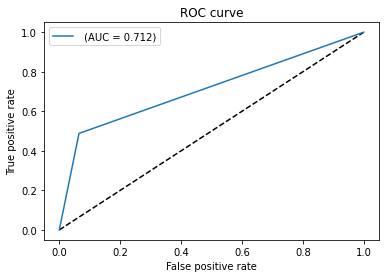

In [82]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnn, tpr_rnn, label=' (AUC = {:.3f})'.format(auc_rnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Confusion matrix, without normalization


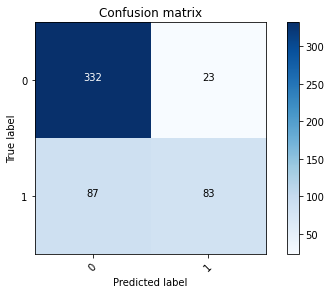

In [83]:
cm = metrics.confusion_matrix(test_set['label'], y_pred_myrnn['prediction'] , labels=[0, 1])
plot_confusion_matrix(cm, classes=[0, 1])

**7.3 RNN with GloVe pre-trarined embedding**

In [84]:
score = myrnn_with_embeddings.evaluate(padded_val_sequences, val_set['label'], verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.39001020789146423
Test accuracy: 0.8368644118309021


In [86]:
y_pred_myrnn_with_glove_embeddings = myrnn_with_embeddings.predict(
    padded_test_sequences, verbose=1, batch_size=2048)

y_pred_myrnn_with_glove_embeddings = pd.DataFrame(y_pred_myrnn_with_glove_embeddings, columns=['prediction'])
y_pred_myrnn_with_glove_embeddings['prediction'] = y_pred_myrnn_with_glove_embeddings['prediction'].map(lambda p: 
                                                                                                    1 if p >= 0.5 else 0)
#y_pred_myrnn_with_glove_embeddings.to_csv('./predictions/y_pred_rnn_with_glove_embeddings.csv', index=False)

1/1 [==============================] - 0s 467ms/step


In [87]:
#y_pred_rnn_with_glove_embeddings = pd.read_csv('./predictions/y_pred_rnn_with_glove_embeddings.csv')
print(accuracy_score(test_set['label'], y_pred_myrnn_with_glove_embeddings['prediction']))
print(metric_precision(test_set['label'],y_pred_myrnn_with_glove_embeddings['prediction']))
print(metric_recall(test_set['label'],y_pred_myrnn_with_glove_embeddings['prediction']))
print(metric_F1score(test_set['label'],y_pred_myrnn_with_glove_embeddings['prediction']))

0.8228571428571428
tf.Tensor(0.7361963190184049, shape=(), dtype=float64)
tf.Tensor(0.7058823529411765, shape=(), dtype=float64)
tf.Tensor(0.7207207207207208, shape=(), dtype=float64)


In [88]:
y_pred_rnn_embed = myrnn_with_embeddings.predict(padded_test_sequences, verbose=1, batch_size=2048).ravel()
fpr_rnn_embed, tpr_rnn_embed, thresholds_rnn_embed = roc_curve(test_set['label'], y_pred_rnn_embed)
auc_rnn_embed = auc(fpr_rnn_embed, tpr_rnn_embed)

1/1 [==============================] - 0s 15ms/step


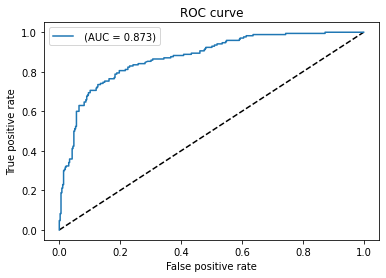

In [89]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnn_embed, tpr_rnn_embed, label=' (AUC = {:.3f})'.format(auc_rnn_embed))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**7.4 CNN**

In [90]:
#模型评估
score = mycnn.evaluate(padded_val_sequences, val_set['label'], verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.36328500509262085
Test accuracy: 0.8389830589294434


In [91]:
y_pred_cnn = mycnn.predict(padded_test_sequences, verbose=1, batch_size=2048).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(test_set['label'], y_pred_cnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)

1/1 [==============================] - 0s 157ms/step


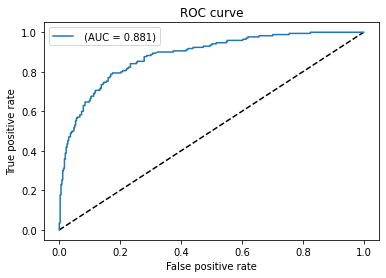

In [92]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label=' (AUC = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [93]:
#best_cnn_model = load_model('./kaggle/working/models/mycnn/weights-improvement-40-0.9821.hdf5')

#y_pred_cnn_multi_channel = best_cnn_model.predict(padded_test_sequences, verbose=1, batch_size=2048)

y_pred_cnn = pd.DataFrame(y_pred_cnn, columns=['prediction'])
y_pred_cnn['prediction'] = y_pred_cnn['prediction'].map(lambda p: 1 if p >= 0.5 else 0)
#y_pred_cnn_multi_channel.to_csv('./predictions/y_pred_cnn_multi_channel.csv', index=False)

In [94]:
#y_pred_cnn_multi_channel = pd.read_csv('./predictions/y_pred_cnn_multi_channel.csv')
print(accuracy_score(test_set['label'], y_pred_cnn['prediction']))
print(metric_precision(test_set['label'],y_pred_cnn['prediction']))
print(metric_recall(test_set['label'],y_pred_cnn['prediction']))
print(metric_F1score(test_set['label'],y_pred_cnn['prediction']))

0.820952380952381
tf.Tensor(0.7435897435897436, shape=(), dtype=float64)
tf.Tensor(0.6823529411764706, shape=(), dtype=float64)
tf.Tensor(0.7116564417177913, shape=(), dtype=float64)


**7.5 RNN+CNN**

In [95]:
score = my_rnn_cnn_model.evaluate(padded_val_sequences, val_set['label'], verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.37095019221305847
Test accuracy: 0.8474576473236084


In [96]:
y_pred_rnncnn = my_rnn_cnn_model.predict(padded_test_sequences, verbose=1, batch_size=2048).ravel()
fpr_rnncnn, tpr_rnncnn, thresholds_rnncnn = roc_curve(test_set['label'], y_pred_rnncnn)
auc_rnncnn = auc(fpr_rnncnn, tpr_rnncnn)

1/1 [==============================] - 1s 520ms/step


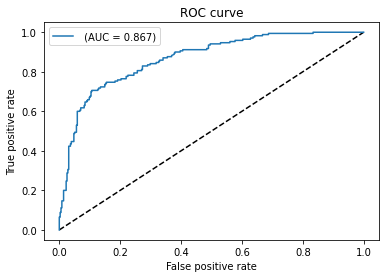

In [97]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnncnn, tpr_rnncnn, label=' (AUC = {:.3f})'.format(auc_rnncnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [98]:
#best_rnn_cnn_model = load_model('./kaggle/working/models/my_rnn_cnn/weights-improvement-14-0.9869.hdf5')

y_pred_rnn_cnn =my_rnn_cnn_model.predict(padded_test_sequences, verbose=1, batch_size=2048)
y_pred_rnn_cnn = pd.DataFrame(y_pred_rnn_cnn, columns=['prediction'])
y_pred_rnn_cnn['prediction'] = y_pred_rnn_cnn['prediction'].map(lambda p: 1 if p >= 0.5 else 0)
#y_pred_rnn_cnn.to_csv('./predictions/y_pred_rnn_cnn.csv', index=False)

1/1 [==============================] - 0s 16ms/step


In [99]:
#y_pred_rnn_cnn = pd.read_csv('./predictions/y_pred_rnn_cnn.csv')
print(accuracy_score(test_set['label'], y_pred_rnn_cnn))
print(metric_precision(test_set['label'],y_pred_rnn_cnn['prediction']))
print(metric_recall(test_set['label'],y_pred_rnn_cnn['prediction']))
print(metric_F1score(test_set['label'],y_pred_rnn_cnn['prediction']))

0.8152380952380952
tf.Tensor(0.7109826589595376, shape=(), dtype=float64)
tf.Tensor(0.7235294117647059, shape=(), dtype=float64)
tf.Tensor(0.717201166180758, shape=(), dtype=float64)


*BERT*

In [ ]:
!pip install keras-bert
!pip install keras-rectified-adama
!pip install tensorflow==2.0.0
!wget -q https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip -o uncased_L-12_H-768_A-12.zip

In [ ]:
SEQ_LEN = 128
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4
import os
pretrained_path = 'uncased_L-12_H-768_A-12/'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [ ]:
from keras_bert import Tokenizer

In [ ]:
token_dict = load_vocabulary(vocab_path)
tokenizer = Tokenizer(token_dict)

In [ ]:
def build_model():
    from keras.layers import BatchNormalization
    model = load_trained_model_from_checkpoint(
        config_path,
        checkpoint_path,
        training=True,
        trainable=True,
        seq_len=SEQ_LEN,
    )

    inputs = model.inputs[:2]
    dense = model.layers[-3].output
    dense2 = keras.layers.Dense(10,activation='relu', kernel_initializer ='glorot_uniform')(dense)
    dense3 = keras.layers.Dense(10,activation='relu', kernel_initializer ='glorot_uniform')(dense2)
    outputs = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform',
                                 name = 'real_output')(dense3)

    

    model = keras.models.Model(inputs, outputs)
       
    return model

In [ ]:
Y = train_set['label'].values

In [ ]:
def convert_data(test_df,DATA_COLUMN):
    global tokenizer
    indices = []
    for i in tqdm(range(len(test_df))):
        ids, segments = tokenizer.encode(test_df[DATA_COLUMN].iloc[i], max_len=SEQ_LEN)
        indices.append(ids)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

In [ ]:
X = convert_data(train_set,'cleaned_content')
X_val  = convert_data(val_set, 'cleaned_content')

In [ ]:
model = build_model()
#model.summary()
decay_steps, warmup_steps = calc_train_steps(Y.shape[0],batch_size=BATCH_SIZE,epochs=EPOCHS,)
model.compile(AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, lr=LR),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
plot_model(model,
          show_shapes=True,
          show_layer_names=True)

In [ ]:
history_bert=LossHistory()

In [ ]:
#from keras.callbacks import *
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              #patience=2, min_lr=1e-7, verbose=1)
BERT = model.fit(
          X, 
          Y, 
          validation_data=(X_val, val_set['label'].values), 
          batch_size=16, 
          callbacks=[history_bert],
          epochs=10, 
          verbose=1
    )

In [ ]:
history_bert.loss_plot('epoch')

In [ ]:
X_test  = convert_data(test_set, 'cleaned_content')

In [ ]:
pred= model.predict(X_test)
pred = pd.DataFrame(pred, columns=['prediction'])
pred['prediction'] =pred['prediction'].map(lambda p: 1 if p >= 0.5 else 0)
fpr_bert, tpr_bert, thresholds_bert = roc_curve(test_set['label'], pred)
auc_bert = auc(fpr_bert, tpr_bert)

In [ ]:
print(accuracy_score(test_set['label'], pred))
print(metric_precision(test_set['label'],pred['prediction']))
print(metric_recall(test_set['label'],pred['prediction']))
print(metric_F1score(test_set['label'],pred['prediction']))

In [ ]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bert, tpr_bert, label=' (AUC = {:.3f})'.format(auc_bert))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()